In [ ]:
!pip install datasets
!pip install transformers==4.31.0
!pip install -U accelerate
!pip install optuna
!pip install optuna-dashboard
!pip install wandb -qU

In [2]:
import transformers

transformers.__version__

'4.31.0'

#Data

In [41]:
from google.colab import drive

drive.mount('/content/drive')

127.0.0.1 - - [17/Sep/2023 16:24:22] "GET /api/studies/0?after=2 HTTP/1.1" 200 3303


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
preprocessing_column = "Light Stemming"

In [5]:
import pickle

with open('/content/drive/MyDrive/emotion_data_tweets/cleaned text data/train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open('/content/drive/MyDrive/emotion_data_tweets/cleaned text data/test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('/content/drive/MyDrive/emotion_data_tweets/cleaned text data/val.pkl', 'rb') as f:
    X_dev = pickle.load(f)

In [6]:
label_to_class = {
    0: 'none',
    1: 'anger',
    2: 'joy',
    3: 'sadness',
    4: 'love',
    5: 'sympathy',
    6: 'surprise',
    7: 'fear'
}

classes = ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

In [7]:
X_train.head()

,tweet,label,tweet_with_replaced_emojis,cleaned_data_with_replaced_emojis,Light Stemming
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,1,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,3,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفرين اعتقال عشرات الشباب قريه باسوطه ريف ...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),3,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,مره اجرب اكون ليك اقرب
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,3,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,0,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...


In [8]:
X_train = X_train[['tweet', preprocessing_column, 'label']]
y_train = X_train['label']
X_test = X_test[['tweet', preprocessing_column, 'label']]
y_test = X_test['label']
X_dev = X_dev[['tweet', preprocessing_column, 'label']]
y_dev = X_dev['label']

In [9]:
X_train.shape, X_test.shape, X_dev.shape

((7045, 3), (1510, 3), (1510, 3))

In [10]:
X_train

,tweet,Light Stemming,label
5081,1996 يا مهند ياحبيبي انت تدور لبش مع اي احد ...,يامهند ياحبيبي تدور لبش اي احد متاكد ابو جاسم ...,1
8264,حلب عفرين اعتقال عشرات الشباب من قريه باسوطه ...,حلب عفر اعتقال عشر الشباب قريه باسوطه ريف عفر ...,3
9777,انا نفسي مره اجرب اكون ليك حد اقرب : ),مره اجرب اكون ليك اقرب,3
740,الصراحه احساس مخزي ونحن نكتفي بالتمثيل المشرف ...,الصراحه احساس مخزي نكتفي بالتمثيل المشرف الاول...,3
6537,57 عاجل الايطالي فابيو باسل يفوز بدهب الاولي...,عاجل الايطالي فابيو باسل يفوز بدهب الاوليمبياد...,0
...,...,...,...
5734,احمد الاحمر اوحش لاعب في الاوليمبياد ... اخره ...,احمد الاحمر اوحش لاعب الاوليمبياد اخره تضخيم ا...,3
5191,انتي كان قصدك عليا !,انتي قصدك عليا,6
5390,يا جدعان لو سمحتوا مش كل واحد عنده ميتين ام عق...,جدع سمحت مش واحد ميت ام عقده نفسيه يروح داخل ش...,1
860,هتودينا في دهيا يا بلال ارحمنا ده مش وقت قلش,هتودي دهيا يابلال ارحم مش قلش,1


In [11]:
X_train = X_train.rename_axis('id')
X_test = X_test.rename_axis('id')
X_dev = X_dev.rename_axis('id')

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_dev = X_dev.reset_index(drop=True)

In [12]:
from datasets import Dataset

X_train = Dataset.from_pandas(X_train)
X_test = Dataset.from_pandas(X_test)
X_dev = Dataset.from_pandas(X_dev)
X_train, X_test, X_dev

(Dataset({
     features: ['tweet', 'Light Stemming', 'label'],
     num_rows: 7045
 }),
 Dataset({
     features: ['tweet', 'Light Stemming', 'label'],
     num_rows: 1510
 }),
 Dataset({
     features: ['tweet', 'Light Stemming', 'label'],
     num_rows: 1510
 }))

#Transformer

##Setup

In [13]:
model_checkpoint = 'UBC-NLP/MARBERTv2'

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [15]:
def tokenize_function(examples):
    return tokenizer(examples[preprocessing_column], padding="max_length", truncation=True, max_length=37)

X_train = X_train.map(tokenize_function, batched=True, num_proc = 8)
X_dev = X_test.map(tokenize_function, batched=True, num_proc = 8)
X_test = X_test.map(tokenize_function, batched=True, num_proc = 8)

Map (num_proc=8):   0%|          | 0/7045 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1510 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1510 [00:00<?, ? examples/s]

##Model

###Train

In [16]:
import numpy as np
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score
                             )

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_precision = precision_score(p.label_ids,preds,average='macro', zero_division=1)
    macro_recall = recall_score(p.label_ids,preds,average='macro', zero_division=1)
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }

In [17]:
import wandb

wandb.login(key="4e35381e2cbc42bf28886d9ae41505c75f15dc8d")

wandb: Currently logged in as: ahmedtawfiiiq (emotion_justification). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
import os

# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="emotion_sentiment_analysis"

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="true"

# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"

In [19]:
import optuna
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW


def objective(trial: optuna.Trial):
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=8)
    # optimizer = AdamW(model.parameters(), lr=1e-5)
    training_args = TrainingArguments(
        output_dir="./train",
        learning_rate=trial.suggest_float("learning_rate", low=1e-5, high=5e-5, log=True),
        # learning_rate = 5.9572096694887074e-05,
        weight_decay=trial.suggest_float("weight_decay", 0.0, 0.1),
        num_train_epochs=trial.suggest_int("num_train_epochs", low=1, high=5),
        # num_train_epochs=4,
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        # per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        # seed = 34,
        seed=trial.suggest_int("seed", 10, 35),
        logging_steps = 100,
        load_best_model_at_end=True,
        evaluation_strategy="steps",
        metric_for_best_model = 'macro_f1', # relative to training metrics to prevent overfitting
        report_to="wandb"
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=X_train,
        eval_dataset=X_dev,
        compute_metrics=compute_metrics,
        # optimizers=(optimizer, None)
    )
    result = trainer.train()
    metrics = trainer.evaluate()
    return metrics["eval_macro_f1"], result.training_loss

In [20]:
# Run optimization
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(storage=storage,
                            study_name="hyper-parameter-search",
                            directions=["maximize", "minimize"],
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=2)

wandb.finish()

[I 2023-09-17 15:57:56,257] A new study created in memory with name: hyper-parameter-search
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Changes to your `wandb` environment variables will be ignored because your `wandb` session has already started. For more information on how to modify your settings with `wandb.init()` arguments, please refer to https://wandb.me/wandb-init.
wandb: Tracking run with wandb version 0.15.10
wand

Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.621500,1.169767,0.580424,0.682107,0.630364,0.647020
200,1.110400,0.971462,0.670305,0.712048,0.684689,0.698675


[I 2023-09-17 15:59:32,964] Trial 0 finished with values: [0.6721954050892932, 1.3321262031658743] and parameters: {'learning_rate': 2.647024526368426e-05, 'weight_decay': 0.03161443556209128, 'num_train_epochs': 1, 'per_device_train_batch_size': 32, 'seed': 13}. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.629800,1.184158,0.552503,0.681613,0.598106,0.618543
200,1.077700,0.908030,0.703083,0.731982,0.704253,0.714570
300,0.883300,0.818018,0.730562,0.742612,0.734118,0.739735
400,0.843100,0.820655,0.737665,0.761651,0.733854,0.743046
500,0.689000,0.775038,0.745126,0.755162,0.746388,0.750331
600,0.568100,0.777544,0.737302,0.748619,0.740669,0.745695
700,0.575400,0.751491,0.754562,0.760779,0.753206,0.756954
800,0.575300,0.751184,0.753524,0.756138,0.752033,0.752318


[I 2023-09-17 16:02:58,720] Trial 1 finished with values: [0.745126428487524, 0.8290072374062744] and parameters: {'learning_rate': 3.445716626454257e-05, 'weight_decay': 0.015627080588734864, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'seed': 23}. 
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:                  eval/accuracy ▂▅▅▁▆▇▇█▇███
wandb:                      eval/loss █▅▅█▄▂▂▁▁▁▁▁
wandb:                  eval/macro_f1 ▂▅▅▁▆▇▇█▇███
wandb:           eval/macro_precision ▁▄▄▁▅▆█▇▇██▇
wandb:              eval/macro_recall ▂▅▅▁▆▇▇█▇███
wandb:                   eval/runtime ▁▁█▂▄▅▇▇▇▇▇▇
wandb:        eval/samples_per_second ██▁▇▅▄▂▂▂▂▂▂
wandb:          eval/steps_per_second ██▁▇▅▄▂▂▂▂▂▂
wandb:                    train/epoch ▂▂▄▄▄▄▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
wandb:              train/global_step ▁▁▂▂▂▂▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇██
wandb:            train/learning_rate ▄▁█▇▆▅▄▃▂▁
wandb:                     train/loss █▅█▄▃▃▂▁▁▁
wandb:              

In [21]:
import optuna
import threading
from google.colab import output
from optuna_dashboard import run_server

# Start Optuna Dashboard
port = 8090
thread = threading.Thread(target=run_server, args=(storage,), kwargs={"port": port})
thread.start()
output.serve_kernel_port_as_window(port, path='/dashboard/')

Bottle v0.12.25 server starting up (using WSGIRefServer())...


<IPython.core.display.Javascript object>

Listening on http://localhost:8090/
Hit Ctrl-C to quit.



###Best Parameters

In [22]:
print(study.best_trials[0].params)

{'learning_rate': 3.445716626454257e-05, 'weight_decay': 0.015627080588734864, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'seed': 23}


In [23]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=8)
training_args = TrainingArguments(output_dir="./results",
                                  logging_steps = 100,
                                  evaluation_strategy="steps")
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=X_train,
                  eval_dataset=X_dev,
                  compute_metrics=compute_metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
for n, v in study.best_trials[0].params.items():
    setattr(trainer.args, n, v)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: WARNING Changes to your `wandb` environment variables will be ignored because your `wandb` session has already started. For more information on how to modify your settings with `wandb.init()` arguments, please refer to https://wandb.me/wandb-init.
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230917_160316-i2ksl7v3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rich-universe-19
wandb: ⭐️ View project at https://wandb.ai/emotion_justification/emotion_sentiment_analysis
wandb: 🚀 View run at https://wandb.ai/emotion_justification/emotion_sentiment_analysis/runs/i2ksl7v3


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
100,1.605000,1.179878,0.593882,0.660863,0.623672,0.641060
200,1.031400,0.892814,0.700865,0.718846,0.704100,0.712583
300,0.915800,0.820167,0.725504,0.732615,0.728534,0.733775
400,0.856700,0.789895,0.732670,0.747867,0.734125,0.739073
500,0.675800,0.800266,0.736442,0.739068,0.737404,0.739735
600,0.593400,0.775361,0.750909,0.759349,0.749639,0.754305
700,0.575800,0.753431,0.754281,0.762298,0.752135,0.756954
800,0.564400,0.744217,0.753948,0.768833,0.751945,0.758940


TrainOutput(global_step=882, training_loss=0.825423632078971, metrics={'train_runtime': 189.593, 'train_samples_per_second': 74.317, 'train_steps_per_second': 4.652, 'total_flos': 267920070177120.0, 'train_loss': 0.825423632078971, 'epoch': 2.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.7339994311332703,
 'eval_macro_f1': 0.7602103614024804,
 'eval_macro_precision': 0.7657291110689279,
 'eval_macro_recall': 0.7584295426044253,
 'eval_accuracy': 0.7615894039735099,
 'eval_runtime': 4.5007,
 'eval_samples_per_second': 335.504,
 'eval_steps_per_second': 41.994,
 'epoch': 2.0}

###Evaluate

####Test Data

In [26]:
import torch

batch_size = 16

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_test]
attention_masks = [i['attention_mask'] for i in X_test]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
test_data = TensorDataset(inputs, masks)

test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [28]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

test_pred = []
for input, masks in test_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    test_pred.extend(predictions)

print(classification_report(X_test['label'], test_pred, target_names=classes))

              precision    recall  f1-score   support

        none       0.71      0.85      0.77       229
       anger       0.73      0.76      0.74       200
         joy       0.66      0.63      0.65       205
     sadness       0.67      0.66      0.67       185
        love       0.79      0.80      0.80       193
    sympathy       0.92      0.90      0.91       156
    surprise       0.69      0.55      0.61       154
        fear       0.95      0.93      0.94       188

    accuracy                           0.76      1510
   macro avg       0.77      0.76      0.76      1510
weighted avg       0.76      0.76      0.76      1510



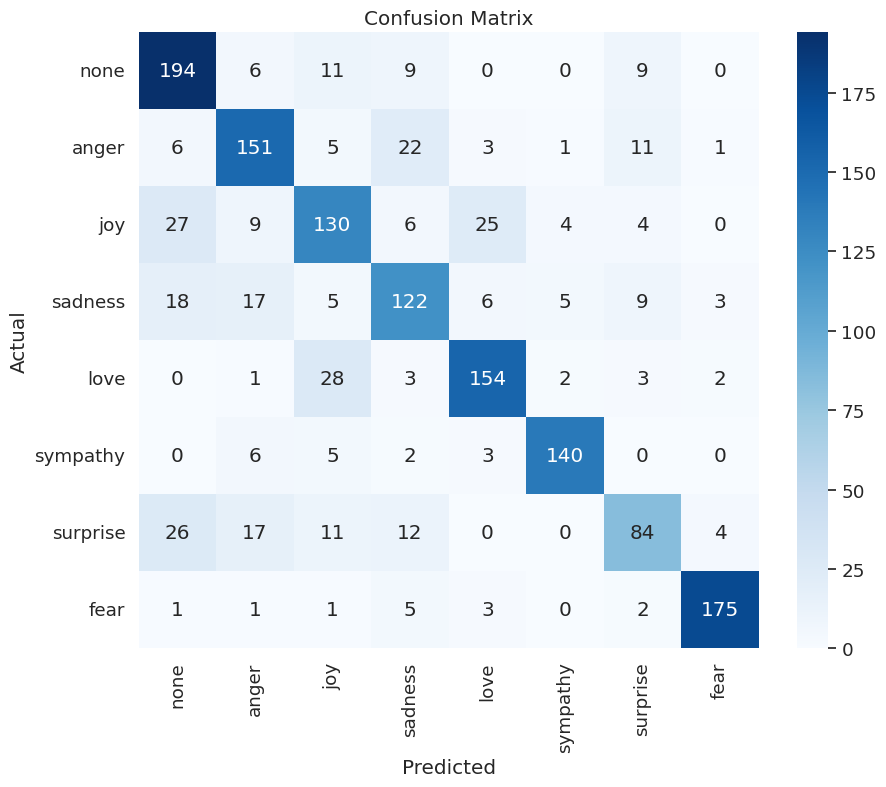

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_test['label'], test_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

####Train Data

In [30]:
from torch.utils.data import TensorDataset, DataLoader

input_ids = [i['input_ids'] for i in X_train]
attention_masks = [i['attention_mask'] for i in X_train]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)
train_data = TensorDataset(inputs, masks)

train_dataloader = DataLoader(train_data, batch_size=batch_size)

In [31]:
from sklearn.metrics import classification_report

model = trainer.model
model.eval()
model.to(device)

train_pred = []
for input, masks in train_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    train_pred.extend(predictions)

print(classification_report(X_train['label'], train_pred, target_names=classes))

              precision    recall  f1-score   support

        none       0.85      0.93      0.89      1074
       anger       0.90      0.94      0.92      1019
         joy       0.84      0.86      0.85       891
     sadness       0.86      0.84      0.85       885
        love       0.91      0.89      0.90       850
    sympathy       0.96      0.96      0.96       755
    surprise       0.86      0.72      0.78       729
        fear       0.98      0.95      0.96       842

    accuracy                           0.89      7045
   macro avg       0.89      0.89      0.89      7045
weighted avg       0.89      0.89      0.89      7045



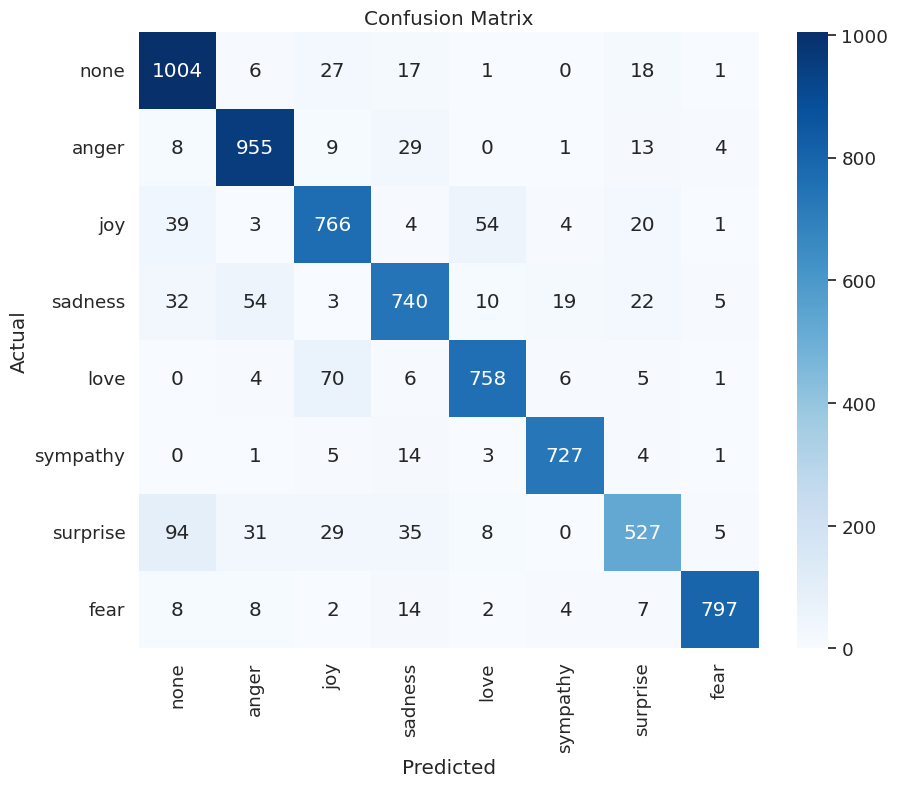

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_train['label'], train_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Saving the model

In [42]:
path = F"/content/drive/MyDrive/emotion_data_tweets/models"
model.save_pretrained(path)

127.0.0.1 - - [17/Sep/2023 16:24:31] "GET /api/studies/0?after=2 HTTP/1.1" 200 3303


##Loading the model

In [43]:
loaded_model = AutoModelForSequenceClassification.from_pretrained(path).to(device)

127.0.0.1 - - [17/Sep/2023 16:26:31] "GET /api/studies/0?after=2 HTTP/1.1" 200 3303
127.0.0.1 - - [17/Sep/2023 16:26:34] "GET /api/studies/0?after=2 HTTP/1.1" 200 3303


####Test Loaded Model

In [44]:
from sklearn.metrics import classification_report

loaded_model.eval()

test_pred = []
for input, masks in test_dataloader:
    torch.cuda.empty_cache()

    input = input.to(device)
    masks = masks.to(device)

    output = loaded_model(input, attention_mask=masks)['logits']
    predictions = torch.argmax(output, dim=1)
    predictions = predictions.cpu().detach().numpy()

    test_pred.extend(predictions)

print(classification_report(X_test['label'], test_pred, target_names=classes))

127.0.0.1 - - [17/Sep/2023 16:28:31] "GET /api/studies/0?after=2 HTTP/1.1" 200 3303
127.0.0.1 - - [17/Sep/2023 16:28:34] "GET /api/studies/0?after=2 HTTP/1.1" 200 3303


              precision    recall  f1-score   support

        none       0.71      0.85      0.77       229
       anger       0.73      0.76      0.74       200
         joy       0.66      0.63      0.65       205
     sadness       0.67      0.66      0.67       185
        love       0.79      0.80      0.80       193
    sympathy       0.92      0.90      0.91       156
    surprise       0.69      0.55      0.61       154
        fear       0.95      0.93      0.94       188

    accuracy                           0.76      1510
   macro avg       0.77      0.76      0.76      1510
weighted avg       0.76      0.76      0.76      1510



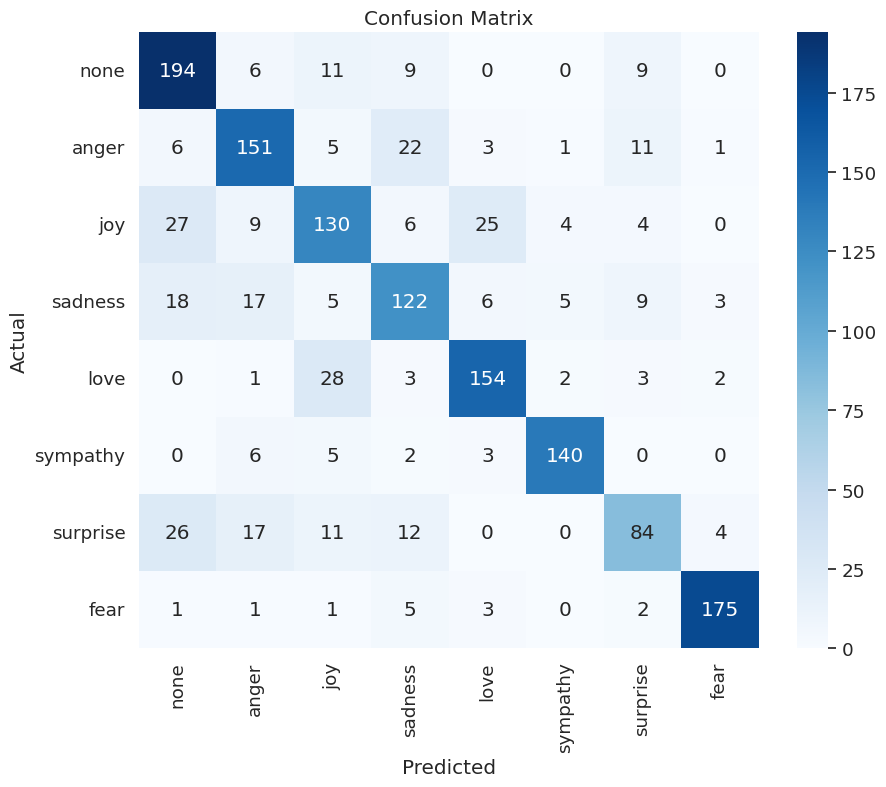

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(X_test['label'], test_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()